In [1]:
import sys
sys.path.append('../30_data_tools/')

In [2]:
import pandas as pd
import plotly.express as px
from datetime import datetime
from scipy.stats import chisquare
from sklearn import preprocessing

In [51]:
from PIL import Image
import numpy as np
import sqlite3
from pathlib import Path
import json

In [4]:
from helper import load_dotenv
from get_labelstudio_data import get_results_of_project

In [5]:
dotenv = load_dotenv()
con = sqlite3.connect( dotenv['DB_PATH'] )

In [6]:
masks = pd.merge(
    pd.read_sql(
        '''
            SELECT m.*, gi.timestamp, gi.config_name FROM mask m
            LEFT JOIN generic_image gi
            ON m.job=gi.job AND m.pdf_filename=gi.pdf_filename
        ''',
        con,
        parse_dates=['timestamp']
    ),
    pd.DataFrame(
        [(r['id'],r['labels'][0]) for r in get_results_of_project(2) if 'id' in r],
        columns=['mask_id','label']
    ),
    how="left",
    on="mask_id"
)

masks.loc[
    (pd.isna(masks.label)) & (masks.ssim >= 0.95),
    'label'
] = 'ssim_no_moire'

# Moirérate

In [ ]:
masks.label.value_counts()

In [ ]:
masks.label.value_counts().checked_moire / masks.shape[0]

In [ ]:
grouped_by_timestamp = masks.loc[
    :,
    ['timestamp','label','mask_id']
].groupby([
    pd.Grouper(key="timestamp", freq="d"),
    'label'
]).count().unstack('label')
grouped_by_timestamp.columns = [c[1] for c in grouped_by_timestamp.columns]
grouped_by_timestamp.loc[:,'moire_ratio'] = grouped_by_timestamp.checked_moire / (
    grouped_by_timestamp.checked_moire + 
    grouped_by_timestamp.checked_no_moire +
    grouped_by_timestamp.ssim_no_moire
)

In [ ]:
px.bar(
    grouped_by_timestamp.moire_ratio,
    labels={
        'timestamp' : 'Tag der Erstellung',
        'value' : 'Anteil der erzeugten Masken mit Moiré'
    }
)

In [ ]:
grouped_by_config = masks.loc[
    pd.isna(masks.config_name) == False,
    ['config_name','label','mask_id']
].groupby([
    'config_name',
    'label'
]).count().unstack('label')
grouped_by_config.columns = [c[1] for c in grouped_by_config.columns]
grouped_by_config.loc[:,'moire_ratio'] = grouped_by_config.checked_moire / (
    grouped_by_config.checked_moire + 
    grouped_by_config.checked_no_moire +
    grouped_by_config.ssim_no_moire
)

In [ ]:
px.bar(
    grouped_by_config.moire_ratio,
    labels={
        'timestamp' : 'Tag der Erstellung',
        'value' : 'Anteil der erzeugten Masken mit Moiré'
    }
)

# Gruppiert nach verwendetem Pattern

In [ ]:
grouped_by_pattern = masks.loc[
    :,
    ['pattern','label','mask_id']
].groupby([
    'pattern',
    'label'
]).count().unstack('label')
grouped_by_pattern.columns = [c[1] for c in grouped_by_pattern.columns]
grouped_by_pattern.loc[:,'moire_ratio'] = grouped_by_pattern.checked_moire / (
    grouped_by_pattern.checked_moire + 
    grouped_by_pattern.checked_no_moire +
    grouped_by_pattern.ssim_no_moire
)
grouped_by_pattern.loc[:,'total_count'] = (
    grouped_by_pattern.checked_moire + 
    grouped_by_pattern.checked_no_moire +
    grouped_by_pattern.ssim_no_moire
)

In [ ]:
px.bar(
    grouped_by_pattern.sort_values('moire_ratio', ascending=False ).total_count,
    labels={
        'timestamp' : 'Tag der Erstellung',
        'value' : 'Anteil der erzeugten Masken mit Moiré'
    }
)

In [ ]:
px.bar(
    grouped_by_pattern.sort_values('moire_ratio', ascending=False ).moire_ratio,
    labels={
        'timestamp' : 'Tag der Erstellung',
        'value' : 'Anteil der erzeugten Masken mit Moiré'
    }
)

# allgemeine Zusammenhänge

In [ ]:
masks.ssim.describe()

In [ ]:
px.scatter(
    masks.ssim.sort_values().reset_index().loc[:,'ssim']
)

In [ ]:
data.shape

In [ ]:
data.loc[
    :,
    [c for c in data.columns if c.startswith('use_')]
].sum()

In [ ]:
data.loc[
    :,
    'area'
] = data.bbox.apply(lambda val: val[2] * val[3])

In [ ]:
data.loc[
    :,
    ['ssim','area']
].corr()

In [ ]:
df= data.loc[
    :,
    'ssim'
].to_frame()

df.loc[
    :,
    'pattern'
] = pd.factorize(data.pattern)[0]

In [ ]:
df.corr('spearman')

In [ ]:
df.corr('pearson')

# Zusammehang: ssim und Flächedeckung

In [ ]:
def get_edge_share( row, edge_limit ):
    img = Image.open( row.img_path ).crop((
        row.bbox[0],
        row.bbox[1],
        row.bbox[0] + row.bbox[2],
        row.bbox[1] + row.bbox[3]
    ))

    k_separation = np.array(img)[:,:,3]
    relevant_part = k_separation[(k_separation < edge_limit) | (k_separation > (255 - edge_limit))]

    return relevant_part.shape[0] / (k_separation.shape[0] * k_separation.shape[1])

In [ ]:
data.loc[
    :,
    'edge_share'
] = data.apply( get_edge_share, args=(10,), axis=1 )

In [ ]:
edge_share = data.edge_share #returns a numpy array
edge_share_normalized = preprocessing.MinMaxScaler().fit_transform(edge_share.to_numpy().reshape((-1,1)))

ssim = data.ssim #returns a numpy array
ssim_normalized = preprocessing.MinMaxScaler().fit_transform(ssim.to_numpy().reshape((-1,1)))

In [ ]:
data.loc[
    :,
    'edge_share_normalized'
] = edge_share_normalized

data.loc[
    :,
    'ssim_normalized'
] = ssim_normalized

In [ ]:
data.loc[
    :,
    ['ssim','edge_share']
].corr()

In [ ]:
data.loc[
    :,
    ['ssim_normalized','edge_share_normalized']
].corr()

In [ ]:
data.iloc[0].img_path

# Kategorien von Masken

In [76]:
data = pd.merge(
    pd.read_sql(
        '''
            SELECT apm.*, m.overlay_intensity_K, m.ssim, m.bbox, gi."timestamp" FROM adjustment_per_mask apm 
            LEFT JOIN mask m
            ON
            	apm.pdf_filename = m.pdf_filename AND
            	apm.job = m.job AND
            	apm."type" = m."type" AND 
            	apm.variant_name = m.variant_name AND 
            	apm."method" = m."method" AND 
            	apm.idx = m.idx AND 
            	apm.mask_id = m.mask_id 
            LEFT JOIN generic_image gi 
            ON
            	apm.pdf_filename = gi.pdf_filename AND
            	apm.job = gi.job AND
            	apm."type" = gi."type" AND 
            	apm.variant_name = gi.variant_name AND 
            	apm."method" = gi."method" AND 
            	apm.idx = gi.idx 
        ''',
        con,
        parse_dates=['timestamp']
    ),
    pd.DataFrame(
        [(r['id'],r['labels'][0]) for r in get_results_of_project(2) if 'id' in r],
        columns=['mask_id','label']
    ),
    how="left",
    on="mask_id"
)

data.loc[
    (data.ssim > 0.95),
    'label'
] = 'ssim_no_moire'

In [77]:
data.shape

(26496, 15)

In [78]:
data.loc[data.mask_id.str.startswith('temp_')].shape

(15478, 15)

In [79]:
grouped_by_mask_id = data.loc[
    :,
    ['mask_id','job']
].groupby(
    'mask_id'
).count().rename(columns={'job':'adjustment_count'})

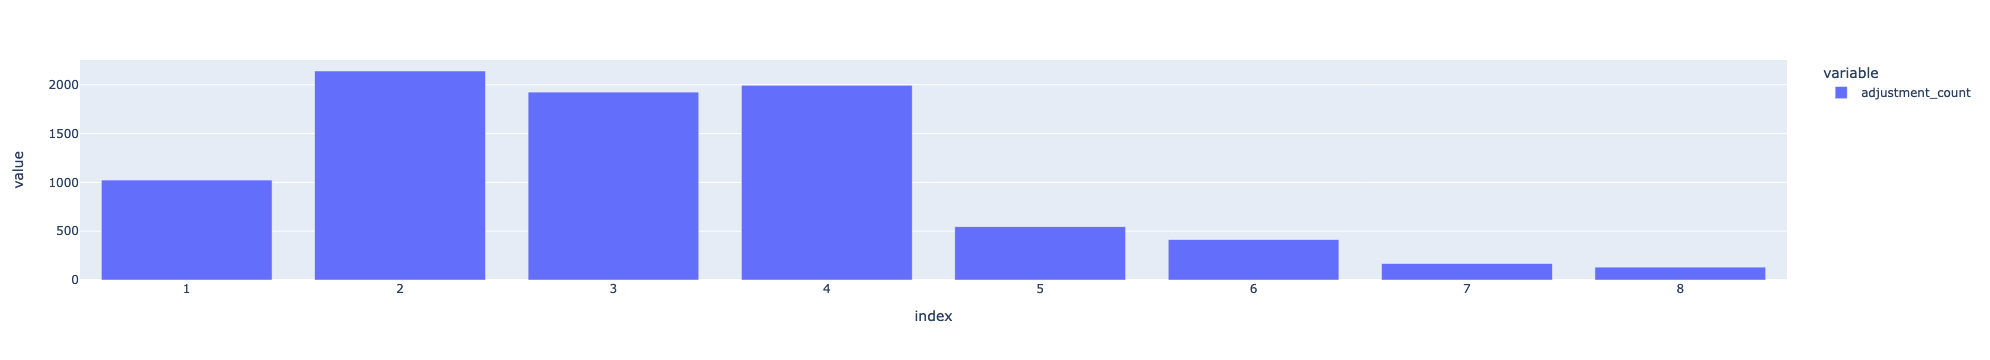

In [80]:
px.bar(grouped_by_mask_id.adjustment_count.value_counts().sort_index())

## Rotation

In [83]:
from sklearn.preprocessing import LabelEncoder

In [84]:
from scipy import stats

In [85]:
le = LabelEncoder()
le.fit(data.loc[
    data.adjustment == 'rotation'
].label.tolist())

LabelEncoder()

In [86]:
X = data.loc[
    data.adjustment == 'rotation'
].features.apply( lambda val: json.loads(val)['rotation_degree'] ).tolist()

y = le.transform(data.loc[
    data.adjustment == 'rotation'
].label.tolist())

In [87]:
stats.pearsonr(X, y)

PearsonRResult(statistic=-0.04879994425056149, pvalue=9.535361231221196e-06)

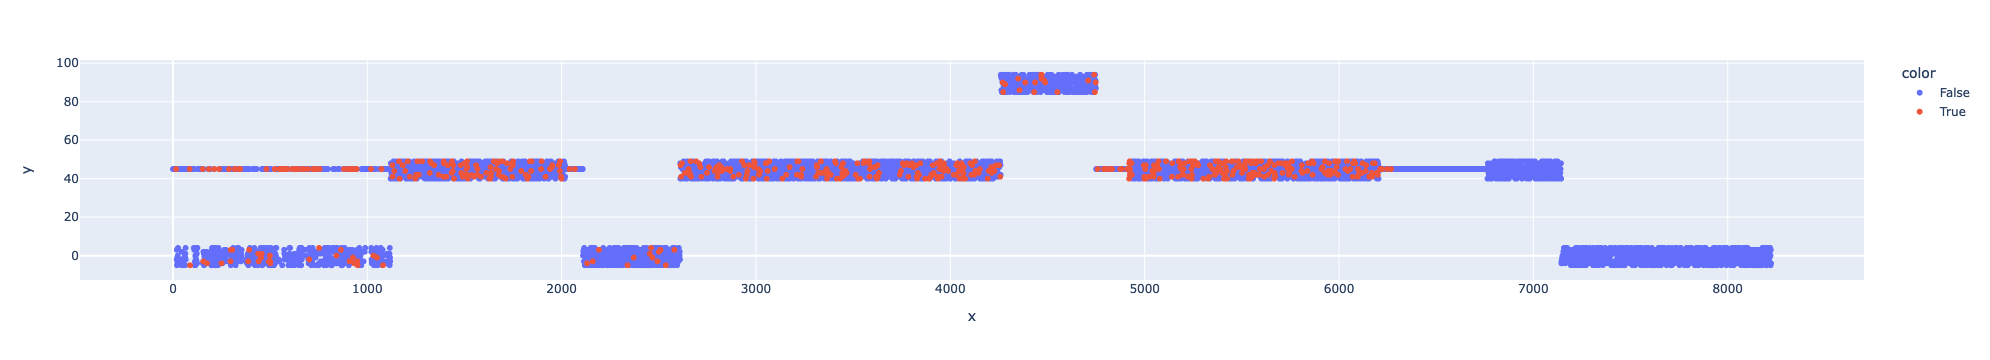

In [88]:
px.scatter(
    y=data.loc[
        data.adjustment == 'rotation'
    ].features.apply( lambda val: json.loads(val)['rotation_degree'] ),
    color=data.loc[
        data.adjustment == 'rotation'
    ].label == 'checked_moire'
)

## Skalierung

In [89]:
X = data.loc[
    data.adjustment == 'scale'
].features.apply( lambda val: json.loads(val)['scale'] ).tolist()

y = le.transform(data.loc[
    data.adjustment == 'scale'
].label.tolist())

stats.pearsonr(X, y)

PearsonRResult(statistic=0.0056971080176748505, pvalue=0.8509057068820968)

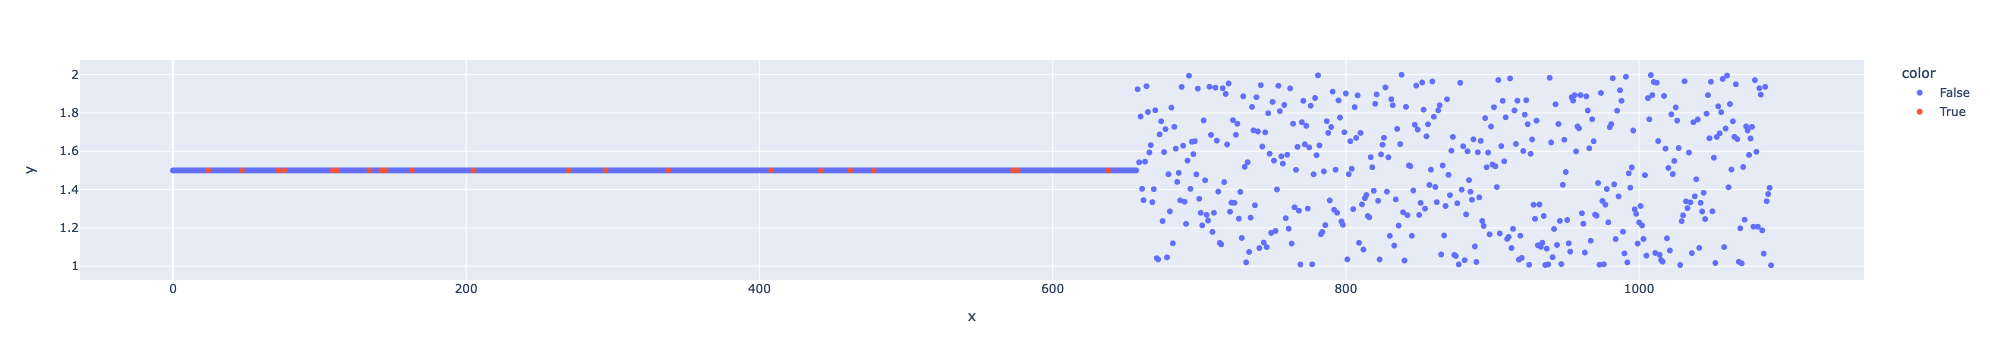

In [91]:
px.scatter(
    y=data.loc[
        data.adjustment == 'scale'
    ].features.apply( lambda val: json.loads(val)['scale'] ),
    color=data.loc[
        data.adjustment == 'scale'
    ].label == 'checked_moire'
)

# perspektivische Verzerrung

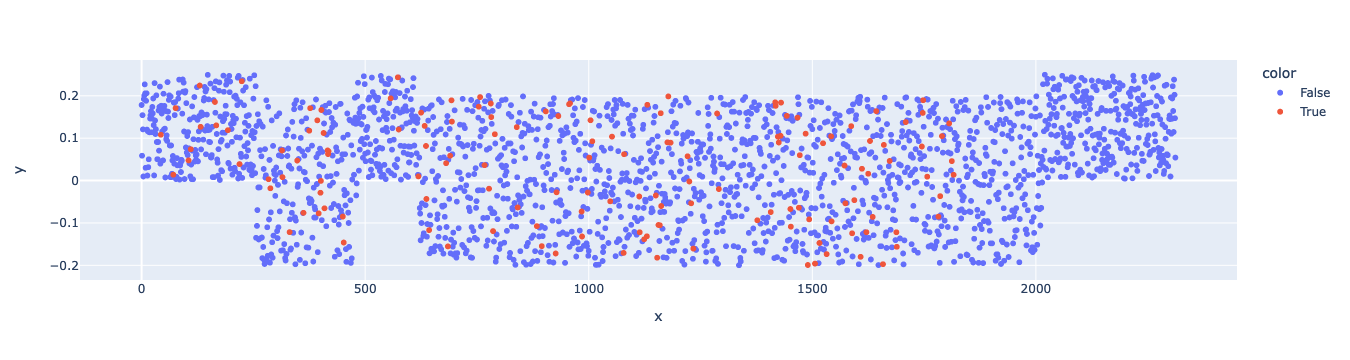

In [96]:
px.scatter(
    y=data.loc[
        data.adjustment == 'uniform_trapezoidal_distortion'
    ].features.apply( lambda val: json.loads(val)['trapezoidal_distortion_strength'] ),
    color=data.loc[
        data.adjustment == 'uniform_trapezoidal_distortion'
    ].label == 'checked_moire'
)

In [97]:
X = data.loc[
    data.adjustment == 'uniform_trapezoidal_distortion'
].features.apply( lambda val: json.loads(val)['trapezoidal_distortion_strength'] ).tolist()

y = le.transform(data.loc[
    data.adjustment == 'uniform_trapezoidal_distortion'
].label.tolist())

stats.pearsonr(X, y)

PearsonRResult(statistic=-0.002504980071824851, pvalue=0.9041593822585743)